# Unsupervised Learning Predict

### Movie Recommender Systems 

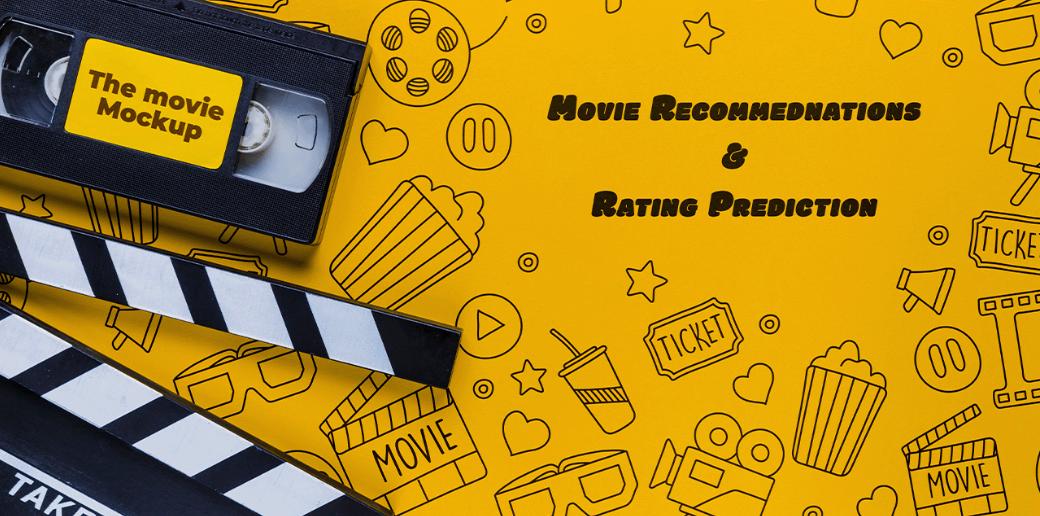

## Collaborators: TeamNM5

  - **Honey Zwane**
    
  - **Ruth Favour Ossai**

  - **Lesego Tiro**
    
  - **Karabo Eugene Hlahla**
    
  

<a id="cont"></a>

## Table of Contents


<a href=#one>1. Introduction</a>

<a href=#two>2. Importing Packages</a>

<a href=#three>3. Loading the Data</a>

<a href=#four>4. Exploratory Data Analysis (EDA)</a>

<a href=#five>5. Data Engineering</a>

<a href=#six>6. Modeling</a>

<a href=#seven>7. Model Performance</a>

<a href=#eight>8. Model Explanations</a>

<a href=#nine>9. Kaggle Submission CSV File</a>

<a href=#ten>10. Comet Experiment</a>

<a href=#eleven>11. Conclusion</a>
   
<a href=#twelve>12. References</a>

<a id="one"></a>
## 1. Introduction
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>



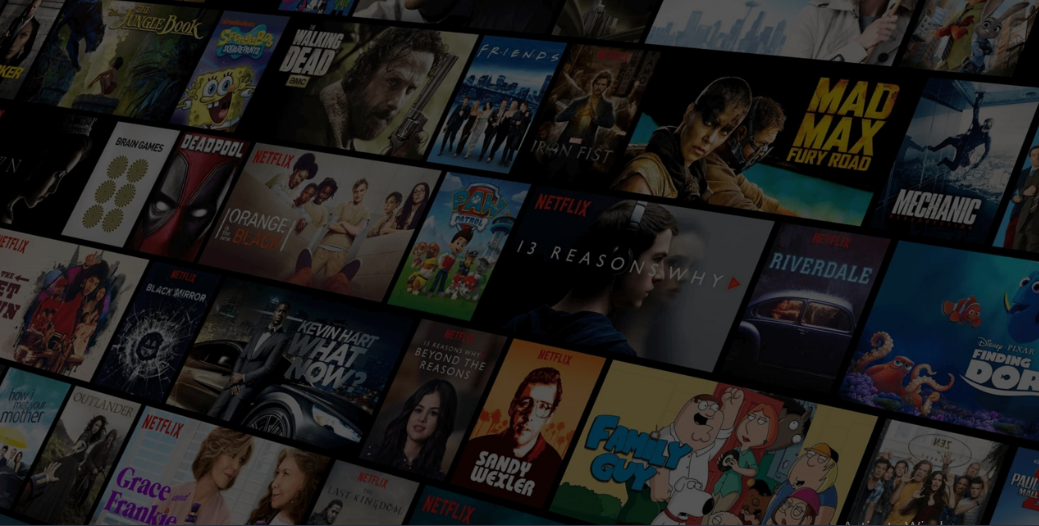

Recommender systems play a vital role in today's technology-driven world by helping individuals make informed choices about the content they engage with daily. This is particularly true for movie recommendations, where intelligent algorithms can assist viewers in discovering great titles from a vast selection. Have you ever wondered how streaming platforms like Netflix, Amazon Prime, Showmax, and Disney seem to know what to recommend to you? In this challenge we will walk you through our movie recommender.

 <a id="two"></a>
## 2. Importing Packages
<a href=#cont>Back to Table of Contents</a>

In [1]:
pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#firstly to import important libraries
import pandas as pd
import numpy as np
import io
#for plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
#for processing the data
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise import SVD
from surprise.model_selection import cross_validate
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
#to display codes without warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<a id="three"></a>
## 3. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

There are a few dataframes that are to be imported, so simply importing the data for now and having the information within displayed a little down the line will help keep the notebook more aestheticaly pleasing.

In [48]:
genome_scores=pd.read_csv("/genome_scores.csv")
genome_tags=pd.read_csv("/genome_tags.csv")
imdb_data= pd.read_csv("/imdb_data.csv")
links= pd.read_csv("/links.csv")
movies= pd.read_csv("/movies.csv")
tags= pd.read_csv("/tags.csv")
df_test=pd.read_csv("/test.csv")
df_train= pd.read_csv("/train.csv")

<a id="four"></a>
## 4. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

Having imported all of the data, it becomes clear that there is a lot of data to go through. This might prove dificult to provide an acurate analysis of the data. So to go through it with more ease, a basic EDA function was created to help show the basic information of each dataframe. this EDA function shows if the dataset has: missing values and also the position of the missing values, outliers and their position as well, check the data types, and lastly the correlation of the data.

In [5]:
def EDA(data):
    """Perform exploratory data analysis on a given dataset.
    Args:
      data (pandas.DataFrame): The dataset to analyze.
    """
    from IPython.display import display
    display(data.head())
    # Check for missing values
    if data.isnull().values.any():
        # Find the number of missing values for each column
        missing_counts = data.isnull().sum()
        # Select only the columns with missing values
        missing_columns = missing_counts[missing_counts > 0]
        print(f"Missing values found in columns: {missing_columns}")
    else:
        print("No missing values found")

    # Check for outliers
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    if outliers.empty:
        print("No outliers found")
    else:
        print(f"Outliers found at positions: {outliers.index}")

    # Check data types
    data_types = data.dtypes
    print(f"Data types: {data_types}")

    # Check correlations
    correlations = data.corr()
    display(correlations)

With EDA function above, now it is easier going through each dataframe and perfom simple data exploration. Below this step is completed swiftly

In [6]:
#fitting the EDA function to the test data as well as the train data
EDA(df_train)

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


No missing values found
Outliers found at positions: RangeIndex(start=0, stop=9069054, step=1)
Data types: userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object


,userId,movieId,rating,timestamp
userId,1.000000,-0.004425,0.002223,-0.001412
movieId,-0.004425,1.000000,-0.008911,0.520675
rating,0.002223,-0.008911,1.000000,0.010106
timestamp,-0.001412,0.520675,0.010106,1.000000


In [7]:
EDA(df_test)

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


No missing values found
Outliers found at positions: RangeIndex(start=0, stop=5000019, step=1)
Data types: userId     int64
movieId    int64
dtype: object


,userId,movieId
userId,1.000000,-0.004401
movieId,-0.004401,1.000000


In [8]:
#firstly the genome score
EDA(genome_scores)

,movieId,tagId,relevance
0,1,1.0,0.02875
1,1,2.0,0.02375
2,1,3.0,0.06250
3,1,4.0,0.07575
4,1,5.0,0.14075


Missing values found in columns: tagId        1
relevance    1
dtype: int64
Outliers found at positions: RangeIndex(start=0, stop=8684486, step=1)
Data types: movieId        int64
tagId        float64
relevance    float64
dtype: object


,movieId,tagId,relevance
movieId,1.000000,-0.000009,0.012154
tagId,-0.000009,1.000000,0.016250
relevance,0.012154,0.016250,1.000000


In [9]:
#genome tags
EDA(genome_tags)

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


No missing values found
Outliers found at positions: RangeIndex(start=0, stop=1128, step=1)
Data types: tagId     int64
tag      object
dtype: object


,tagId
tagId,1.0


In [10]:
#for the imdb data
EDA(imdb_data)

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


Missing values found in columns: title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64
Outliers found at positions: RangeIndex(start=0, stop=27278, step=1)
Data types: movieId            int64
title_cast        object
director          object
runtime          float64
budget            object
plot_keywords     object
dtype: object


,movieId,runtime
movieId,1.00000,-0.13273
runtime,-0.13273,1.00000


In [11]:
#the movies dataframe
EDA(movies)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


No missing values found
Outliers found at positions: RangeIndex(start=0, stop=62423, step=1)
Data types: movieId     int64
title      object
genres     object
dtype: object


,movieId
movieId,1.0


In [12]:
#now the tags
EDA(tags)

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


Missing values found in columns: tag    16
dtype: int64
Outliers found at positions: RangeIndex(start=0, stop=1093360, step=1)
Data types: userId        int64
movieId       int64
tag          object
timestamp     int64
dtype: object


,userId,movieId,timestamp
userId,1.000000,-0.101326,-0.197582
movieId,-0.101326,1.000000,0.400216
timestamp,-0.197582,0.400216,1.000000


In [13]:
EDA(links)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


Missing values found in columns: tmdbId    107
dtype: int64
Outliers found at positions: RangeIndex(start=0, stop=62423, step=1)
Data types: movieId      int64
imdbId       int64
tmdbId     float64
dtype: object


,movieId,imdbId,tmdbId
movieId,1.000000,0.466805,0.581131
imdbId,0.466805,1.000000,0.820764
tmdbId,0.581131,0.820764,1.000000


From the above information, it becomes clear that the data contains a few columns missing values, with  missing values found in the 'imdb_data' in only four columns and as well on 'tags' and 'links' having missing value. As for the outliers, the data seems have quite a few outliers. This could be due to the diversity of the data, how the data was entered or a myriad of other reasons. It might prove more fruitful to display the data numerical data and see how much of the data is outlier prone. The data types seem to show that the prominent datatypes are intergers and objects with only 2 columns being float datatypes.

#### Checking the columns with null values
We will have to see how much of the columns from the data which were found to have nulls is missing and if these missing values can be fixed by filling them in anyway or if they have to be dropped later on in the data handling phase

In [14]:
#to check the percantage of missing data
director_nulls= imdb_data['director'].isnull().mean()
runtime_nulls= imdb_data['runtime'].isnull().mean()
tmdbId_nulls= links['tmdbId'].isnull().mean()
tag_nulls= tags['tag'].isnull().mean()
plot_keywords_nulls= imdb_data['plot_keywords'].isnull().mean()
budget_nulls= imdb_data['budget'].isnull().mean()
# print the percentage of missing data
print("Percentage of missing data in column 'director': {:.2f}%".format(director_nulls*100))
print("Percentage of missing data in column 'runtime': {:.2f}%".format(runtime_nulls*100))
print("Percentage of missing data in column 'budget': {:.2f}%".format(budget_nulls*100))
print("Percentage of missing data in column 'plot_keywords': {:.2f}%".format(plot_keywords_nulls*100))
print("Percentage of missing data in column 'tag': {:.2f}%".format(tag_nulls*100))
print("Percentage of missing data in column 'tmdbId': {:.2f}%".format(tmdbId_nulls*100))

Percentage of missing data in column 'director': 36.20%
Percentage of missing data in column 'runtime': 44.32%
Percentage of missing data in column 'budget': 71.02%
Percentage of missing data in column 'plot_keywords': 40.61%
Percentage of missing data in column 'tag': 0.00%
Percentage of missing data in column 'tmdbId': 0.17%


It would seem that a noticeable chunk of the columns with missing data actually has missing data, with an exception of the 'tag' and the 'tmdbId' column, as it seems the missing values are negligible. This can be seen visually below in the bar chart. This will be addressed in the data handling.

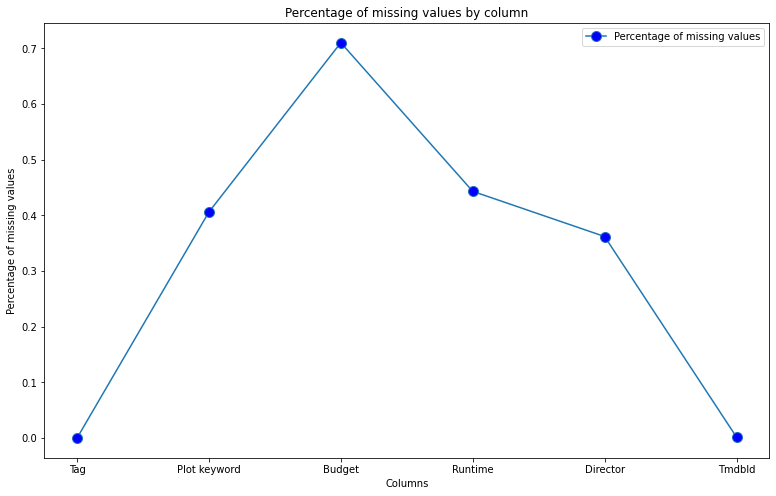

In [15]:
missing_data={'Tag': tag_nulls, 'Plot keyword': plot_keywords_nulls, 'Budget': budget_nulls,
              'Runtime': runtime_nulls, 'Director': director_nulls, 'TmdbId':tmdbId_nulls}
missing_data = pd.DataFrame(list(missing_data.items()),columns= ['Columns', 'Percentage of missing values'])

missing_data.plot(kind='line',x='Columns',y='Percentage of missing values',  
                  marker='o', linestyle='-', markersize=10, markerfacecolor='blue', figsize=(13, 8))
plt.xlabel('Columns')
plt.ylabel('Percentage of missing values')
plt.title('Percentage of missing values by column')
plt.show()

For more visuals, one would perhaps want to see what relationships can be infered from the data sets or what relationships could be interesting to explore. This will require some creative thinking since some key columns such as budget and runtime are missing a significant amount of data

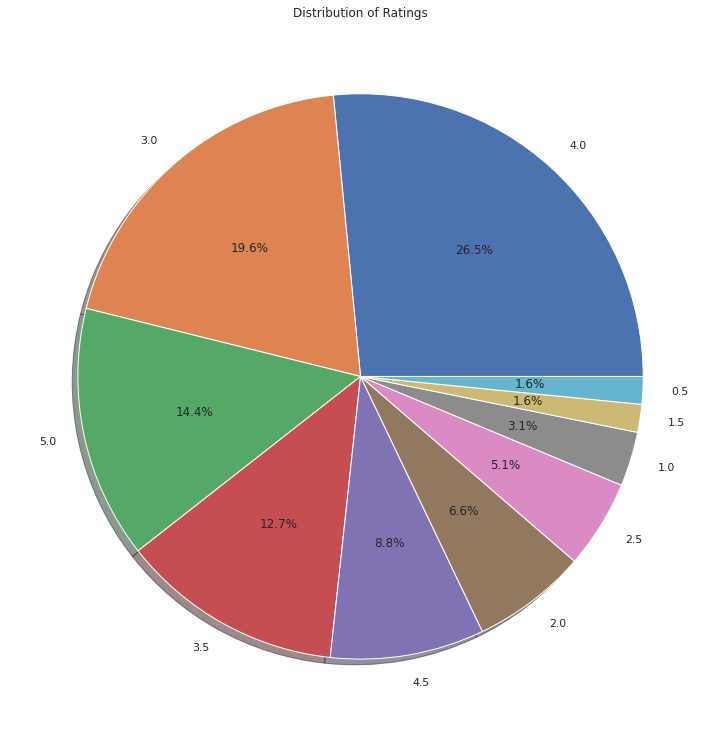

In [16]:
# Visualize the distribution of ratings
sns.set(rc={'figure.figsize':(27,13)})
rating_counts = df_train['rating'].value_counts()
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', shadow=True)
plt.title('Distribution of Ratings')
plt.show()

but the exploration of the data sets does not end there. When movies are being titled, there could be a method in which movie titles are chosen in way that could results in higher rating or better responses from the audiance. A word cloud can be used to show the most popular words in titles.

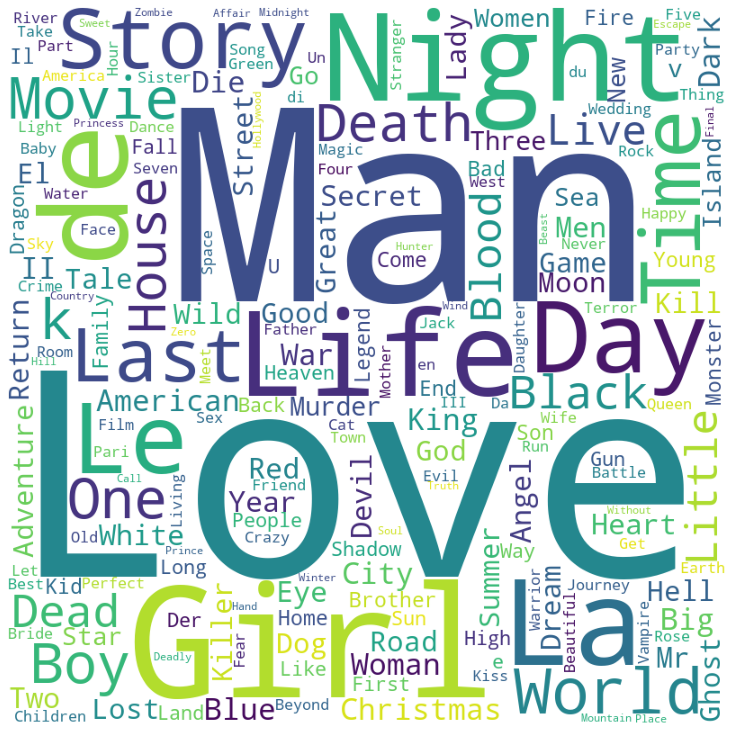

In [17]:
#create a set of english stopwords
stopwords = set(stopwords.words('english'))
#create a list of all the words in the 'title' column
words = ' '.join(movies['title'])
#create a wordcloud object
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(words)

# plot the wordcloud
plt.figure(figsize = (15, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

From the wordcloud it becomes apparent that words like Love, Man and Girl are largly popular when naming a movie. One could, at this point only speculate as to what role naming does to the popularity of a movie. Although it can be said that the name of the movie does play an important role in being as discriptive, eye catching and as relevant as possible so as to attract the intended target market.

With the basic exploration of the data done as much as possibe without making any changes to the data. It becomes clear that few relationships can be visualised from the data. To solve this, the Data has to be cleaned and try exploring the data further.

<a id="five"></a>
## 5. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

From the Exploratory Data Analysis, it was made clear that the columns from the imdb data are lacking a significant amount of information. In this phase of the project, it is important to drop those columns. But one thing that needs to be noted is that the aim of the project is to build a recommender for both  content based filtering and collaborative based filtering. This will have to kept in mind when changes are made. for instance, for content based filtering, columns such as genre, actors, director and budget might prove vital. hence it would not be adviseable to drop the the columns from the imdb dataframe completely. to deal with the missing values found in the EDA, dropping the rows with empty columns would be more productive so as to keep the information.

In [47]:
#to drop the empty rows
imdb_data.dropna(inplace=True)

Another thing that is visible is the plot keywords and title actor columns have the names mixed up, this might cause issues in the data not being properly displayed. To solve this, spliting the words using the split method would make the information more accessible. However the Imdb dataframe is not the only one with this issue, the column genre from also has the same issue. The same remedy will be applied to it as well.

In [19]:
#splitting the data from imdb_data
imdb_data[['plot_keywords', 'title_cast']] = imdb_data[['plot_keywords', 'title_cast']].apply(lambda x: x.str.split('|'))
imdb_data = imdb_data.explode('plot_keywords')
imdb_data = imdb_data.explode('title_cast')

In [20]:
#separating any null values
movies = movies[~movies["genres"].isnull()]
#splitting the genre column
movies["genres"] = movies["genres"].str.split("|")
movies = movies.explode("genres")

When looking at the title column from movies, the movie names are structured in a way where by it is 'movie_name (year of release)'. this might prove inconvinient when searching for a movie, so extracting the year of release and removing it from the data could save time and make the code run more efficiently.

In [21]:
movies['title'] = movies['title'].str.extract('(.*) \(.*\)', expand=False)

Once those columns have been dealt with, the next step is moving into creating dataframe that would be suitable for the purposes of thi project. firstly, since this is an unsupervised machine learning project. the df_test does not have a rating column, to create it below. Also the time stamp column from df_train does not serve a purpose when it come to getting the ratings. so it will have to dropped.

In [22]:
df_test['rating'] = df_test.assign(rating=None)['rating'].astype(float)
df_test

,userId,movieId,rating
0,1,2011,NaN
1,1,4144,NaN
2,1,5767,NaN
3,1,6711,NaN
4,1,7318,NaN
...,...,...,...
5000014,162541,4079,NaN
5000015,162541,4467,NaN
5000016,162541,4980,NaN
5000017,162541,5689,NaN


In [23]:
#dropping the timestamp column
df_train=df_train.drop(['timestamp'], axis=1)

The one thing that must be avoided at all costs is having unnecessary data cluttering up the models. Below, a new data frame was created specifically for the content based filtering. 

In [24]:
#feautures we want to keep
movies_genre = movies[['movieId','genres', 'title']]
cast = imdb_data[['movieId', 'title_cast']]
# Group the data by movieId in both dataframes
movies_genre = movies_genre.groupby('movieId').agg({'genres': '|'.join, 'title': 'first'})
cast = cast.groupby('movieId').agg({'title_cast': '|'.join})
# Merge the grouped dataframes on movieId
df_train2 = pd.merge(df_train, movies_genre, on='movieId', how='left')
df_train2 = pd.merge(df_train2, cast, on='movieId', how='left')
df_train2

,userId,movieId,rating,genres,title,title_cast
0,5163,57669,4.0,Comedy|Crime|Drama|Thriller,In Bruges,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...
1,106343,5,4.5,Comedy,Father of the Bride Part II,Steve Martin|Diane Keaton|Martin Short|Kimberl...
2,146790,5459,5.0,Action|Comedy|Sci-Fi,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2),Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...
3,106362,32296,2.0,Adventure|Comedy|Crime,Miss Congeniality 2: Armed and Fabulous,Sandra Bullock|Regina King|Enrique Murciano|Wi...
4,9041,366,3.0,Drama|Horror|Mystery|Thriller,Wes Craven's New Nightmare (Nightmare on Elm S...,Jeff Davis|Heather Langenkamp|Miko Hughes|Matt...
...,...,...,...,...,...,...
9069049,103675,4963,4.5,Crime|Thriller,Ocean's Eleven,George Clooney|Cecelia Ann Birt|Paul L. Nolan|...
9069050,150244,3852,3.0,Comedy,"Tao of Steve, The",NaN
9069051,140794,2058,4.0,Action|Crime|Drama|Mystery|Thriller,"Negotiator, The",Samuel L. Jackson|Kevin Spacey|David Morse|Ron...
9069052,37156,1584,2.5,Drama|Sci-Fi,Contact,Jena Malone|David Morse|Jodie Foster|Geoffrey ...


With the data engineering part done, the exploration of the data can continue.

### Second EDA

To continue with the EDA and exploring the kind of relationships that can be displayed once the data is cleaned. Now features which were not able to be displayed prior to cleaning such as the top rated genres in general can be easily displayed. 

Below the top 20 highly rated genres is displayed.

highest rated genres

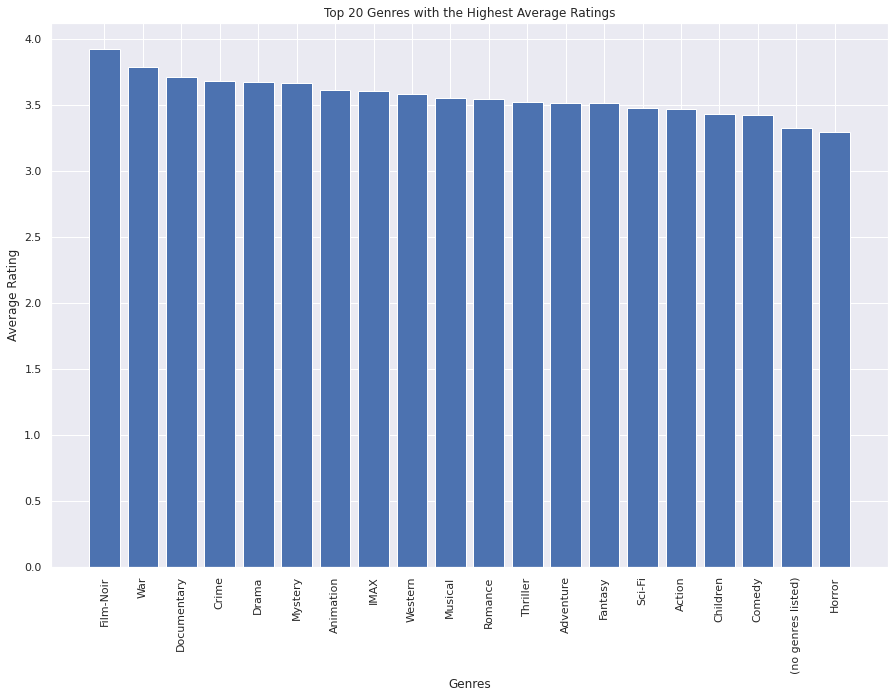

In [25]:
# Join the two dataframes based on the common column movieId
merged_df = pd.merge(df_train, movies, on='movieId')
# Group the data by the genres column and calculate the mean rating for each genre
genre_ratings = merged_df.groupby('genres')['rating'].mean().reset_index()
# Sort the data by mean rating in descending order
genre_ratings = genre_ratings.sort_values('rating', ascending=False)
# Keep only the top n genres
n = 20
genre_ratings = genre_ratings.head(n)

# Plot the genres with the highest ratings
plt.figure(figsize=(15, 10))
plt.bar(genre_ratings['genres'], genre_ratings['rating'])
plt.xlabel('Genres')
plt.ylabel('Average Rating')
plt.title(f'Top {n} Genres with the Highest Average Ratings')
plt.xticks(rotation=90)
plt.show()


From the graph, it becomes clear that novelty genres like Film Noir and War are the two most highly rated genres. It could be a play into the rarity and the unusualness of the films. Also seeing documentary, crime and drama in the top 5 most rated genres is quite intersting and could tell what the public is generally interested in. This can be used by executives to see which movies to direct or for companies that stream movies, what kind of movies to include more in their plartfom.

With this said, which movies have on average the highest ratings?
below, the top 20 films with the highest ratings are displayed.

In [26]:
#Join the two dataframes based on the common column movieId
merged_df = pd.merge(df_train, movies, on='movieId')
#Group the data by the genres column and calculate the mean rating for each genre
genre_ratings = merged_df.groupby('title')['rating'].mean().reset_index()
#Sort the data by mean rating in descending order
genre_ratings = genre_ratings.sort_values('rating', ascending=False)
#Keep only the top n genres
n = 20
genre_ratings = genre_ratings.head(n)
#Display the genres with the highest ratings as a table
print(genre_ratings[['title', 'rating']])

                                                   title  rating
41372                                          Unraveled     5.0
29609                                            Removal     5.0
16439    Histoire(s) du Cinéma: The Coin of the Absolute     5.0
13771                                        Front Cover     5.0
38488             The Second Awakening of Christa Klages     5.0
13803                             Fuchsia the Mini-Witch     5.0
38485  The Seasons in Quincy: Four Portraits of John ...     5.0
25875                                      Nordexpressen     5.0
1922                               All Things Fall Apart     5.0
13807                                    Fuck for Forest     5.0
10909                       Dragons: A Fantasy Made Real     5.0
35086                               That Guy Dick Miller     5.0
24548                                  Muay Thai Fighter     5.0
37011                              The Iceman Interviews     5.0
38465                    

Seeing the top 20 highest rated movies and genres, it would be interesting to see the directors relationships to the actors. Firstly seeing which directors have worked with the most actors overall, This is a great indicator to show who works well with others. Which in the long term, helps the investor gauge who they would like to invest in when it comes to directors. 

Below the top 25 directors with the most actors worked with is displayed.

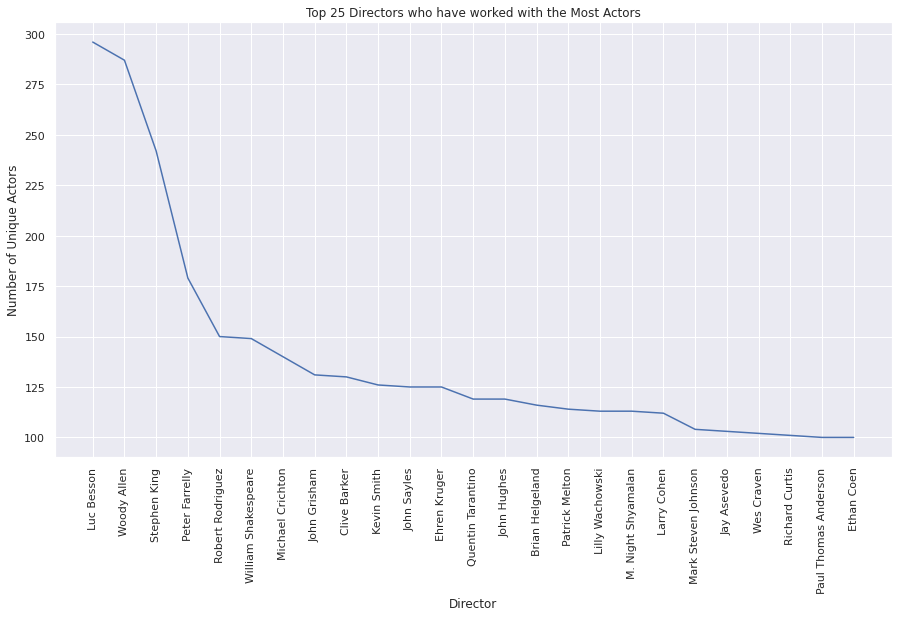

In [27]:
# Create a new dataframe that contains only the director, cast, and movieId columns
df_director_cast = imdb_data[['director', 'title_cast', 'movieId']]
# Group the data by the director and count the number of unique actors they have worked with
director_actor_counts = df_director_cast.groupby(['director'])['title_cast'].nunique().reset_index()
# Sort the data by the number of unique actors in descending order
director_actor_counts = director_actor_counts.sort_values('title_cast', ascending=False)
# Keep only the top 20 directors
top_25 = director_actor_counts.head(25)

# Plot the line graph
plt.figure(figsize=(15, 8))
plt.plot(top_25['director'], top_25['title_cast'])
plt.xlabel('Director')
plt.ylabel('Number of Unique Actors')
plt.title('Top 25 Directors who have worked with the Most Actors')
plt.xticks(rotation=90)
plt.show()

A few interesting insights come up, first to be note is how the grap almost plateus around 125 actors. This could be due to the level of experience directors have or the willingness of actors to work with the directors. A funny observation is seeing how the list includes directors like classical playwright, actor and poet William Shakespeare. Who died in the year 1616

If that is the case, it might be intersting to see which actors have acted in the most amount of movies. This also helps in seeing who more popular to work with. Which is a good sign because making movies is an art but still a business. You want to have the best possible cast, best director and the best production team.

To show the actors with the most movies, the graph below is shown:

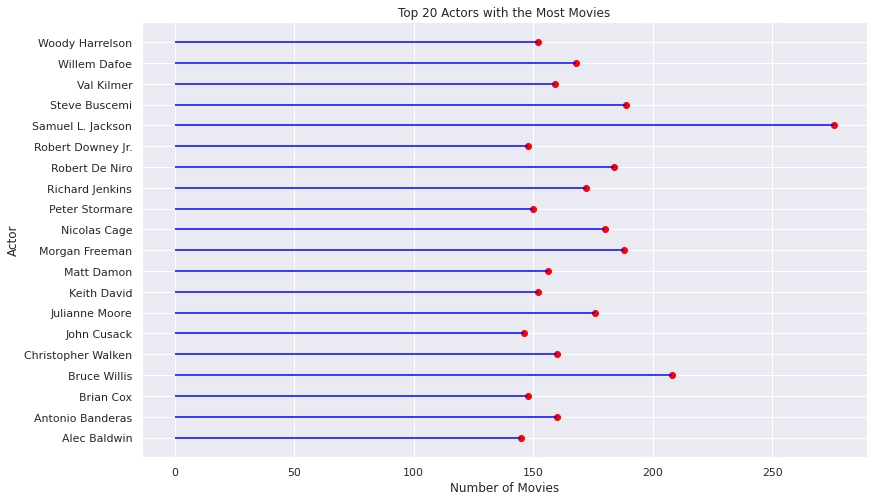

In [28]:
# Count the number of movies each actor appears in
actor_counts = imdb_data['title_cast'].value_counts()
# Only keep the top 20 actors
actor_counts = actor_counts.head(20)
# Sort the actors alphabetically
actor_counts = actor_counts.sort_index()

# Plot the data as a lollipop chart
plt.figure(figsize=(13,8))
plt.hlines(y=actor_counts.index, xmin=0, xmax=actor_counts.values, color='blue')
plt.scatter(x=actor_counts.values, y=actor_counts.index, color='red')
plt.xlabel("Number of Movies")
plt.ylabel("Actor")
plt.title("Top 20 Actors with the Most Movies")
plt.show()

From above, by a huge margin, Samuel L. Jackson is the most popular actor. Followed by Bruce Willis, who also leads by a sizable margin. This is a good indicator to show the actors experience and value. 

There are plenty of relationships that could be explored and displayed. It can really be done ad nauseam. With the visualisations done already. some key relationships can be drawn. But before closing off this part of the project. Let us look at the directors with the longest runtime. One can compare this with the number of actors a director has worked with. It can also show which directors are given the most creative freedom during filming.

to plot directors with the highest runtimes:

In [29]:
pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


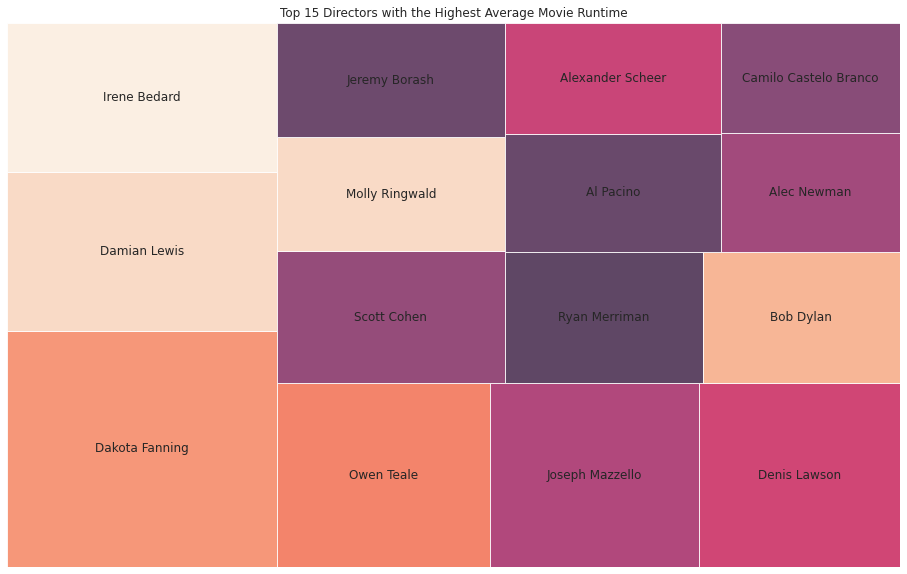

In [30]:
import squarify
import matplotlib.pyplot as plt

# Calculate the average runtime for each director
director_runtime = imdb_data.groupby("director")["runtime"].mean().reset_index()
# Sort the directors by average runtime in descending order
director_runtime = director_runtime.sort_values("runtime", ascending=False)
# Keep only the top 15 directors with the highest average runtime
director_runtime = director_runtime.head(15)

# Plot the Treemap
plt.figure(figsize=(16, 10))
squarify.plot(sizes=director_runtime["runtime"], label=director_runtime["director"], alpha=.8)
plt.axis('off')
plt.title("Top 15 Directors with the Highest Average Movie Runtime")
plt.show()

What is quite interesting to see is how the directors shown here are different from the directors who have worked with the most amount of actors. It could be drawn that a longer runtime is not popular amongst actor. Also runtime does affect production costs, meaning a movie needs to gross more for it to break even. Translating to a higher risk when it comes to the return of investment.

With the exploration of the data done, the project can continue to build the models and fit them

<a id="six"></a>
## 6. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In this part of the project, various models will be fit into the data with the sole purpose of firstly getting the rating a user will give to a movie and secondly to create a recommender based of the details of a movie. That said, to get the content based recommender out of the way, we can build the model before the others.


## Content based filtering model

below is a function that calls the top 10 movies that are closely related to a specifie movie. This is not personalised to each user, it gives out to the movies related in a cosine similarity. A deeper explanation will be given in the model explaination phase of the project so as to do justice to this simple yet effective model

In [31]:
# Extract the feature columns into a separate dataframe
features = ['title', 'genres']
df_features = df_train2[features].drop_duplicates().head(20000)
# Replace NaN values with empty strings
df_features.fillna("", inplace=True)
# Concatenate the title and genre columns into a single string
df_features['combined_features'] = df_features['title'] + " " + df_features['genres']
# Use TfidfVectorizer to compute the term frequency-inverse document frequency matrix
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english', max_features=10000)
tfidf_matrix = tf.fit_transform(df_features['combined_features'])
# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix)
# Create a movie index mapping from movie title to movieId
indices = pd.Series(df_features.index, index=df_features['title'])

# Function that takes in movie title as input and outputs the top 10 recommended movies
def content_based_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]
    # Compute the similarity scores of all movies with the input movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the movieIds of the top 10 most similar movies
    movieIds = [i[0] for i in sim_scores[1:11]]
    # Return the top 10 recommended movies
    return df_features['title'].iloc[movieIds]

# Test the recommendation function
print(content_based_recommendations("Toy Story That Time Forgot"))

86612                    Toy Story of Terror
137669          People That Time Forgot, The
12135                            Toy Story 4
119                                Toy Story
1049                             Toy Story 2
3701                             Toy Story 3
15822       Toy Story Toons: Partysaurus Rex
244966            Toy Story Toons: Small Fry
175374    Toy Story Toons: Hawaiian Vacation
72776                               Toy, The
Name: title, dtype: object


For the specified movie: 'toy story that time forgot', some of the top recommendations are other toy story movies and other movies with similar names. what is beautiful to note is how closely related these movies are. Not only by name but also by genre. over 60% of the recommended movies are animations.

## Collaborative based filtering model

Now, To determine the ratings users will give to a certain movie given only their previous movie rating and also the movies they rated. To undertake this task, the first model used is the KMeans model. This model will be explained properly in the model explanation and its efficacy displayed in that section as well. But right now, it was chosen for it's simplicity, speed and easy to interprete results.

In [32]:
from sklearn.cluster import KMeans

# create a k-means model
kmeans = KMeans(n_clusters=3, random_state=0)
# fit the model to the data
kmeans.fit(df_train[['userId', 'movieId']])
# predict the cluster for each data point
kmeans_predictions = kmeans.predict(df_test[['userId', 'movieId']])

Now with our base model complete, we can move on to the second model. For this model, the SVD model was chosen for it popularity of being used method in recommender systems due to its ability to uncover latent features in the data and its computational efficiency.

However given the data size,it becomes prompted to use a smaller sample of the data because although SVD is computationally efficient, it does not work magic. 

In [33]:
from surprise import SVD, Dataset, Reader, accuracy
# Reduce the sample size of the data
df_train = df_train.sample(frac=0.1)
df_test = df_test.sample(frac=0.1)

reader = Reader(rating_scale=(0.5, 5.0))
# Load the train and test data into surprise's dataset format
train_data = Dataset.load_from_df(df_train[['movieId','userId', 'rating']], reader)
test_data = Dataset.load_from_df(df_test[['movieId', 'userId', 'rating']], reader)
# Split the data into training and test sets
train_set = train_data.build_full_trainset()
test_set = test_data.build_full_trainset().build_testset()
# Train the model using the SVD algorithm
algo = SVD()
algo.fit(train_set)
# Predict ratings for the test set
svd_predictions = algo.test(test_set)

Given that the svd model had to be used in a smaller sample. we could also use a version of it that is more powerful to run the code. The SVDpp or The SVD++ algorithm takes into account both explicit and implicit feedback in the data, making it a more robust method for recommendation.

In [34]:
from surprise import SVDpp

# Create a reader object to specify the rating scale (0.5 to 5.0 in this case)
reader = Reader(rating_scale=(0.5, 5.0))
# Load the train and test data into the surprise dataset format
train_data = Dataset.load_from_df(df_train[['userId', 'movieId', 'rating']].head(5000019), reader)
test_data = Dataset.load_from_df(df_test[['userId', 'movieId', 'rating']].head(5000019), reader)
# Split the data into training and test sets
train_set = train_data.build_full_trainset()
test_set = test_data.construct_testset(test_data.raw_ratings)
# Train the SVDpp model
algo = SVDpp()
algo.fit(train_set)

# Predict ratings for the test set
SVDpp_predictions = algo.test(test_set)

Once the models have been fitted, the next step will be Model explanation along with the review of their perfomance.

<a id="seven"></a>
## 7. Model Perfomance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [49]:
from surprise import accuracy

# For SVD
SVD_predictions = SVDpp_predictions
SVD_true = df_train['rating']
SVD_rmse = np.sqrt(mean_squared_error(SVD_true, SVD_predictions))

# For KMEANS
kmeans_predictions = kmeans_predictions
kmeans_true = df_tain['rating']
means_rmse = np.sqrt(mean_squared_error(kmeans_true, kmeans_predictions))

# For SVDPP
SVDpp_predictions = SVDpp_predictions
SVDpp_true = df_tain['rating']
SVDpp_rmse = np.sqrt(mean_squared_error(SVDpp_true, SVDpp_predictions))

print("SVD RMSE: ", svd_rmse)
print("kmeans RMSE: ", kmeans_rmse)
print("SVDPP RMSE: ", SVDpp_rmse)

In [ ]:
# Set the x-axis labels to be the names of the models
model_names = ['SVD', 'kmeans', 'SVDpp']
# Set the y-axis values to be the RMSE values for each model
rmse_values = [svd_rmse, kmeans_rmse, SVDpp_rmse]
# Create the bar plot
plt.bar(model_names, rmse_values)
# Add a title and axis labels
plt.title('Model RMSE Values')
plt.xlabel('Models')
plt.ylabel('RMSE')
# Show the plot
plt.show()

<a id="eight"></a>
## 8. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

## 1. Content-Based Filtering



Recommender systems are the true pillars of todays entertaiment with media outlets such as movies and music streaming websites and apps utilising and depending on them heavily to keep their clients happy and returning to use their services. The first model that was built was a simple recommender system based on the content of a specified movie. It gives the same recommendation to everyone, regardless of the user's personal interest. For the model, Cosine Similarity is used to calculate a numeric quantity that denotes the similarity between two movies. Mathematically, it is defined as follows:

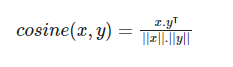

Since the TF-IDF Vectorizer is used, calculating the Dot Product will directly give us the Cosine Similarity Score. For that we have to consider metadata (or content), hence, it also known as Content Based Filtering. In our case we considered the movie title and genres. This allows the recommender to be efficient while still being able to work through the data without exhausting the computational power.

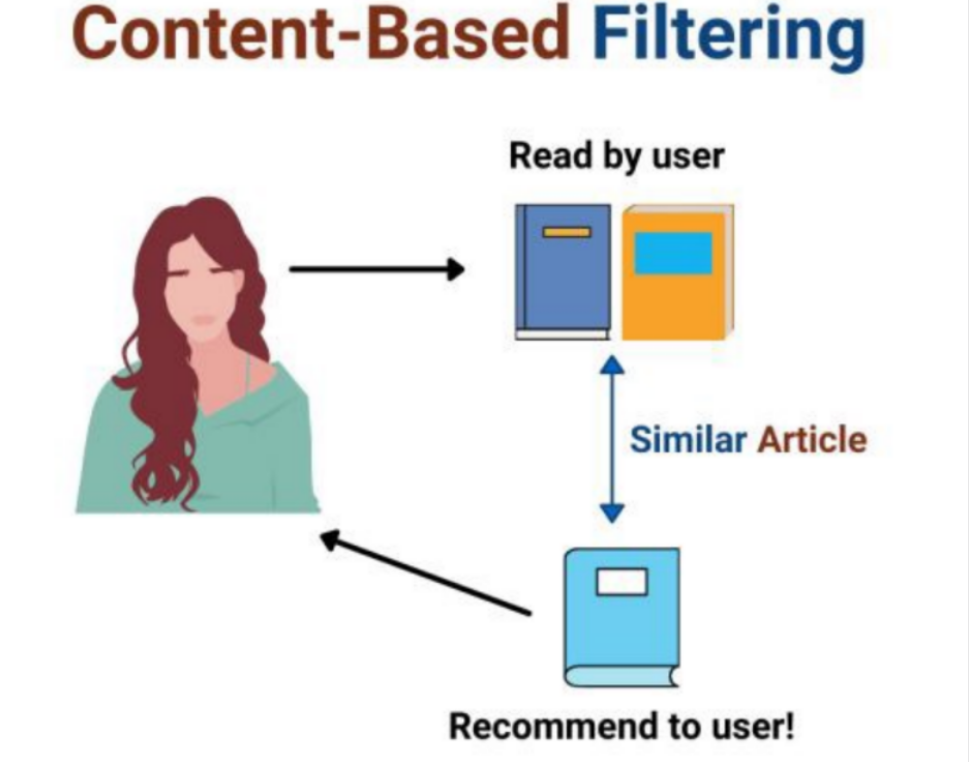

## 2. Collabborative Based Filtering




Collaborative filtering is a method of making recommendations or predictions about a user's preferences or interests based on the preferences or interests of similar users. It works by identifying patterns in the behavior of different users and using that information to make predictions about future behavior. The idea is that users who have similar preferences in the past are likely to have similar preferences in the future. This model is often used in recommendation systems, such as those used by online retailers or streaming services to suggest new products or media to customers. It is a good model because it is able to make accurate recommendations without needing to know much about the products or users themselves, relying instead on the patterns of behavior between users

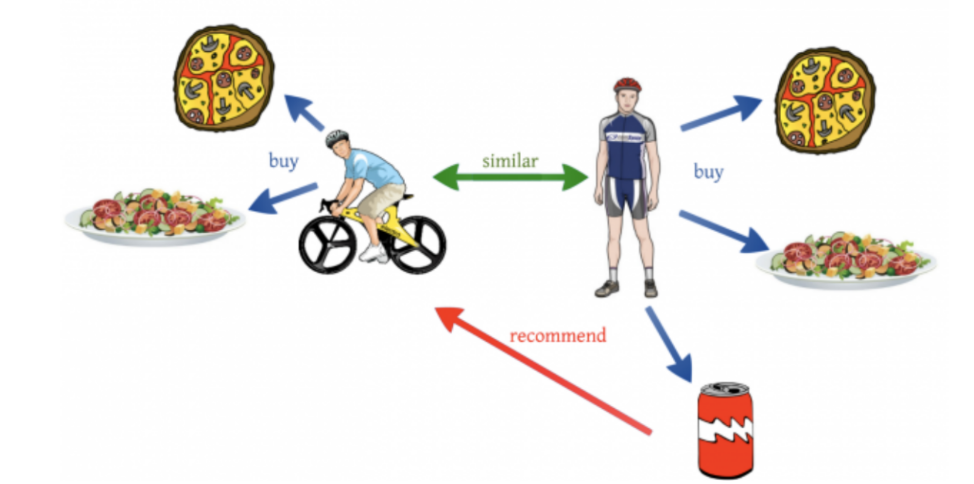

Even the models it uses are different. The most common model for working with data cluster is the K-Means model, but when working with movie recommenders. It becomes clear that this simple model is just not robust enough to handle the needs of the recommender, this prompts the search for and use of different models. When researching, it seems another model that works well for movie recommenders is the SVD model.

##  SVD




SVD (Singular Value Decomposition) is a popular technique in recommendation systems. It decomposes a matrix into simpler components to find patterns in the data, which are then used to make predictions about missing values. It is preferred for recommendation systems as it efficiently handles sparse matrices, common in real-world datasets, and provides a low-dimensional representation of the data for further analysis. Also, SVD can handle both explicit (e.g., ratings) and implicit (e.g., clicks) feedback, making it a versatile tool for recommendation systems. In essence, SVD helps predict a user's preferences based on their past behavior by identifying patterns in the data.

## SVDPP




SVDpp is a variation of the SVD algorithm in recommendation systems that incorporates implicit feedback data to make more accurate predictions. It factorizes a large matrix of user-item interactions into two matrices with reduced dimensions, representing users and items, and refines these matrices using implicit feedback. This makes SVDpp a popular recommendation algorithm, able to handle large-scale and sparse data and effectively capture complex relationships between users and items. As a result, it is widely used in various applications, such as online shopping, video streaming, and news recommendation systems.

## K-Means




K-Means is a machine learning technique that is used to divide data into similar groups. The goal of the algorithm is to find the best grouping solution that minimizes the sum of squared distances between each data point and the center of its group. The algorithm works by repeating the process of adjusting the group centroids and reassigning data points until the solution reaches convergence. The end result is K clusters of data points with their own centroids. K-Means is widely used for customer segmentation, image compression, and anomaly detection due to its ability to handle large datasets and find patterns in data.

<a id="nine"></a>
## 9. Kaggle Submission File
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

Once the models have been fitted and evaluated as to which one best fits 

In [45]:
predicted_ratings = []

# Step 2: Iterate through the svg_pred list and append the est attribute to the list
for pred in svd_predictions:
    predicted_ratings.append(pred.est)

Here to create a submission file

In [50]:
#creating a rating column
df_test['rating']=predicted_ratings
#creating a Id column
df_test['Id'] = df_test['userId'].astype(str) + '_' + df_test['movieId'].astype(str)
#removing the userId and movieId colums since they arent necessary for the submission
df_test = df_test.drop(['userId', 'movieId'], axis=1)
#finally rounding off the values in the rating column to one decimal place.
df_test['rating'] = df_test['rating'].round(1)

In [51]:
#reindexing the submission file
submission = df_test.reindex(columns=['Id', 'rating'])
submission.to_csv('submission.csv', index=False)
submission.head()

<a id="eleven"></a>
# 11. Conclusion
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In conclusion, movie recommendation systems can be built using either content based filtering or collaborative based filtering. Content based filtering utilizes the attributes of a movie such as genre, actors, and director to recommend similar movies to the user. This method has the advantage of not requiring any past behavior of the user and can provide recommendations even for new users. However, it is limited in that it cannot handle the problem of cold start, where there is little information available about the user, and it may not always provide the most accurate recommendations.

Collaborative based filtering, on the other hand, relies on the behavior of other users to make recommendations. This method can provide more personalized recommendations, but it also has its limitations, such as the problem of sparse data, where there is little interaction between users and items, and it can also suffer from the filter bubble effect where it only recommends similar items to what the user has seen before.

In terms of models, the most commonly used ones include Singular Value Decomposition (SVD), K-Means, and the SVD++. Each of these models has its own strengths and weaknesses and the choice of model would depend on the specific requirements of the recommendation system being built.

In conclusion, both content based and collaborative based filtering have their advantages and disadvantages, and the choice between the two methods would depend on the specific requirements of the recommendation system being built.

<a id="twelve"></a>
# 12. References
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


"Survey of Clustering Algorithms" by Jain, A. K., and Dubes, R. C.

"An Introduction to Unsupervised Learning via Scaled Subspace Clustering" by Shiliang Sun, Xiaofeng He and Jiawei Han

Kaggle's Unsupervised Learning Course

Coursera's Unsupervised Learning in Python

DataCamp's Unsupervised Machine Learning in Python

Kaggle Datasets